In [4]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

In [5]:
# 读取数据（确保正确处理空格）
df = pd.read_csv('D:\\2024test.csv', skipinitialspace=True)  # 跳过初始空格

# 检查 radiation 列
print("是否存在 NaN:", df["radiation"].isna().any())
print("是否存在 Inf:", np.isinf(df["radiation"]).any())
print("唯一值示例:", df["radiation"].unique()[:10])  # 查看前10个唯一值
print("最大值:", df["radiation"].max())
print("最小值:", df["radiation"].min())
# 移除空格并转换为 float
df["radiation"] = df["radiation"].astype(str).str.strip().replace("", np.nan).astype(float)

是否存在 NaN: False
是否存在 Inf: False
唯一值示例: [  0.    23.68 357.38 582.58 706.73 763.16 766.68 717.16 591.71 371.44]
最大值: 993.52
最小值: 0.0


In [6]:
# 读取数据（确保正确处理空格）
df = pd.read_csv('D:\\2025test.csv', skipinitialspace=True)  # 跳过初始空格

# 检查 radiation 列
print("是否存在 NaN:", df["radiation"].isna().any())
print("是否存在 Inf:", np.isinf(df["radiation"]).any())
print("唯一值示例:", df["radiation"].unique()[:10])  # 查看前10个唯一值
print("最大值:", df["radiation"].max())
print("最小值:", df["radiation"].min())
# 移除空格并转换为 float
df["radiation"] = df["radiation"].astype(str).str.strip().replace("", np.nan).astype(float)

是否存在 NaN: False
是否存在 Inf: False
唯一值示例: [  0.    22.45 546.64 667.86 714.28 704.38 667.82 524.63 266.39   0.75]
最大值: 1077.88
最小值: 0.0


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 加载训练集和验证集数据（2024年数据）
train_val_data = pd.read_csv('D:\\2024test.csv')
X_train_val = train_val_data.drop(columns=['O3','date'])
y_train_val = train_val_data['O3']

# 加载独立的测试集数据（2025年数据）
test_data = pd.read_csv('D:\\2025test.csv')
X_test = test_data.drop(columns=['O3','date'])
y_test = test_data['O3']

# 从训练+验证集中划分训练集和验证集（90%训练，10%验证）
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size=0.1,  # 10%作为验证集
    random_state=42
)

# 检查划分比例
print("="*50)
print("数据集划分比例：")
print(f"训练集 (2024年部分): {len(X_train) / len(X_train_val):.1%}")
print(f"验证集 (2024年部分): {len(X_val) / len(X_train_val):.1%}")
print(f"测试集 (2025年完整数据): {len(X_test)}条记录")
print("="*50)

数据集划分比例：
训练集 (2024年部分): 90.0%
验证集 (2024年部分): 10.0%
测试集 (2025年完整数据): 10329条记录


In [12]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'booster': 'gbtree',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'random_state': 42
    }

    model = XGBRegressor(**params, early_stopping_rounds=10)
    
    # 使用验证集进行早停
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=0
    )
    
    # 预测验证集并计算RMSE
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

# 创建优化研究
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=False)

# 输出最佳参数
best_params = study.best_params
best_params.update({
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 42
})
print("\n" + "="*50)
print(f"最佳超参数: {best_params}")
print("="*50)

# 使用最佳参数训练最终模型（使用全部2024年数据）
final_model = XGBRegressor(**best_params)
final_model.fit(
    X_train_val,  # 使用全部2024年数据训练
    y_train_val,
    verbose=0
)

# 在独立测试集（2025年数据）上预测
y_pred = final_model.predict(X_test)

# 计算评估指标
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 打印结果
print("\n" + "="*50)
print("Xgboost模型在2025年测试集上的表现：")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print("="*50)

[I 2025-07-10 17:43:57,456] A new study created in memory with name: no-name-1828853e-329f-4cf3-a4f6-48f8acc64a22
[I 2025-07-10 17:44:01,248] Trial 0 finished with value: 9.832019930546704 and parameters: {'max_depth': 8, 'learning_rate': 0.06962104533120916, 'subsample': 0.8493894199150265, 'colsample_bytree': 0.9296812093006053, 'min_child_weight': 5, 'n_estimators': 756, 'gamma': 0.9103978455132898}. Best is trial 0 with value: 9.832019930546704.
[I 2025-07-10 17:44:02,588] Trial 1 finished with value: 12.10355503948344 and parameters: {'max_depth': 5, 'learning_rate': 0.038840597908105415, 'subsample': 0.5302932213829082, 'colsample_bytree': 0.6868213048193007, 'min_child_weight': 1, 'n_estimators': 707, 'gamma': 0.04956045189735314}. Best is trial 0 with value: 9.832019930546704.
[I 2025-07-10 17:44:04,109] Trial 2 finished with value: 30.47006894101492 and parameters: {'max_depth': 4, 'learning_rate': 0.0014713370826532866, 'subsample': 0.1027738203764062, 'colsample_bytree': 0.1


最佳超参数: {'max_depth': 10, 'learning_rate': 0.03610085103381596, 'subsample': 0.4938757885696238, 'colsample_bytree': 0.8256132939624689, 'min_child_weight': 5, 'n_estimators': 1000, 'gamma': 0.9279187192984901, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'random_state': 42}

Xgboost模型在2025年测试集上的表现：
RMSE: 16.6678
MSE: 277.8158
MAE: 11.8543
R²: 0.8298


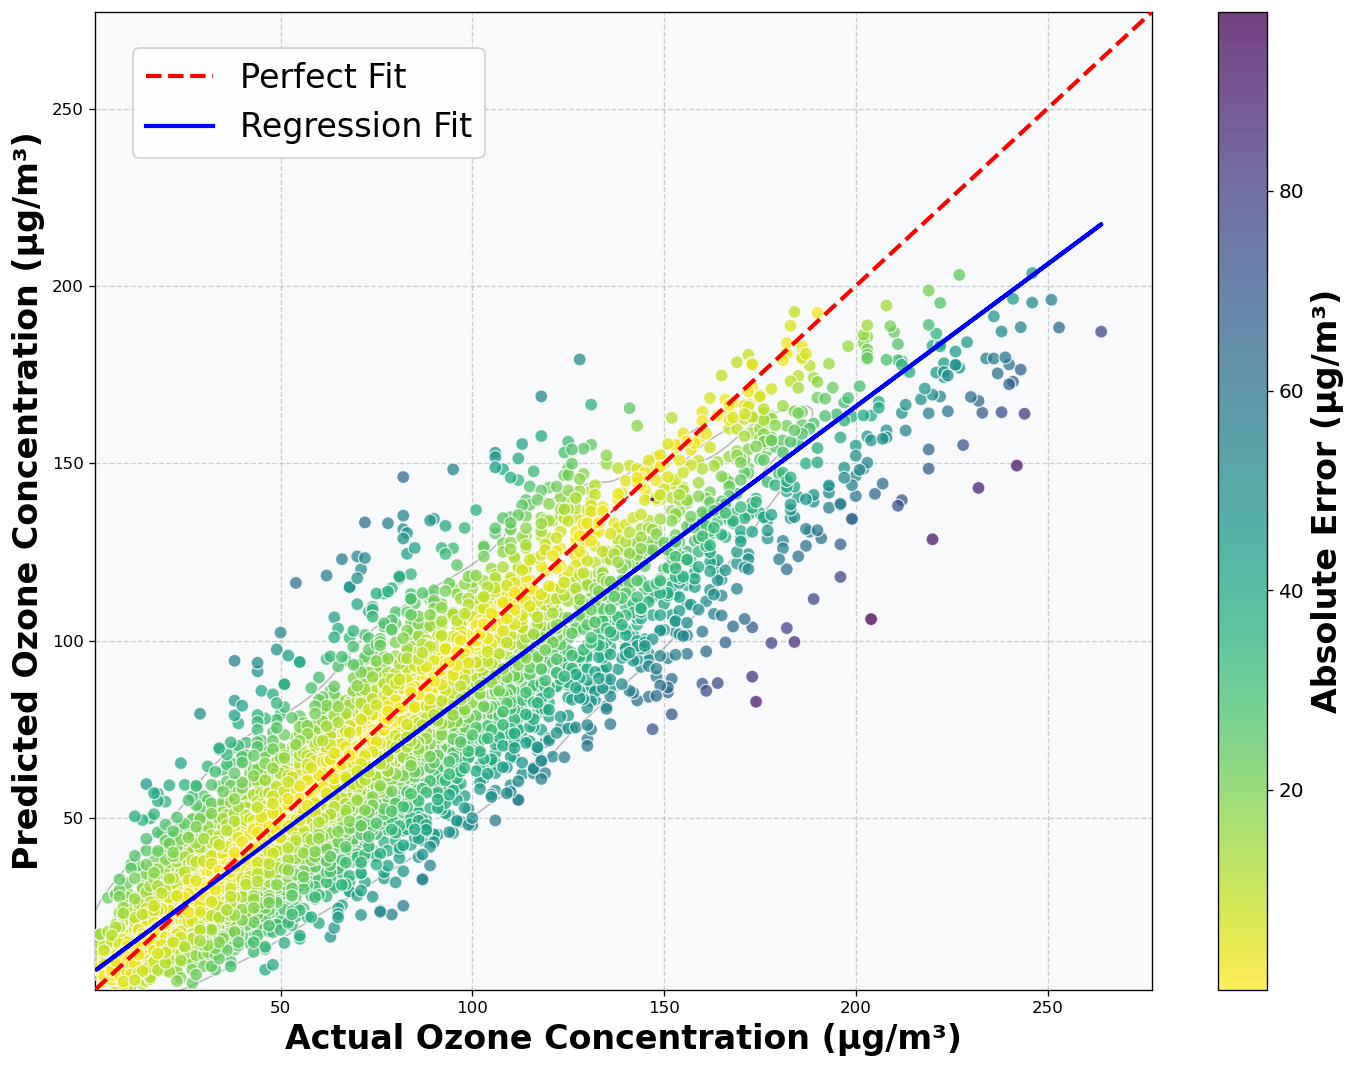

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math

# Set global plotting parameters
plt.figure(figsize=(12, 9), dpi=120)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False  # Fix negative sign display

# 1. Create scatter plot
scatter = plt.scatter(y_test, y_pred, 
                    c=np.abs(y_test - y_pred),  # Color represents error magnitude
                    cmap='viridis_r',  # Reversed colormap for better visibility of high errors
                    alpha=0.75, 
                    s=60, 
                    edgecolor='w', 
                    linewidth=0.8,
                    zorder=3)  # Lower zorder to ensure lines are on top

# 2. Add perfect fit line (red dashed)
min_val = min(y_test.min(), y_pred.min()) * 0.95
max_val = max(y_test.max(), y_pred.max()) * 1.05
perfect_fit, = plt.plot([min_val, max_val], [min_val, max_val], 
                      'r--', linewidth=2.5, label='Perfect Fit', zorder=5)  # Higher zorder

# 3. Add regression fit line (blue solid)
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, y_pred)
reg_line = slope * y_test + intercept
reg_fit, = plt.plot(y_test, reg_line, 
                  'b-', linewidth=2.5, 
                  label='Regression Fit', zorder=5)  # 较高图层顺序

# Calculate angle between two lines
m1 = 1.0  # Slope of perfect fit line (y = x)
m2 = slope  # Slope of regression line

# Avoid division by zero
if abs(1 + m1 * m2) > 1e-6:
    angle_rad = abs(math.atan((m2 - m1) / (1 + m1 * m2)))
    angle_deg = abs(math.degrees(angle_rad))
else:
    angle_deg = 90.0  # Lines are perpendicular

# 4. Calculate and display evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# #Create metrics text
# metrics_text = (
#    f'$R^2$ = {r2:.3f}\n'
#     f'RMSE = {rmse:.2f} μg/m³\n'
#    f'MAE = {mae:.2f} μg/m³\n'
#     f'Samples = {len(y_test)}\n'
#     f'Angle = {angle_deg:.1f}°'
# )

# #Add semi-transparent text box
# plt.text(0.05, 0.95, metrics_text, 
#         transform=plt.gca().transAxes, fontsize=14,
#         verticalalignment='top',
#         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 6. Set axis labels and title
plt.xlabel('Actual Ozone Concentration (μg/m³)', fontsize=20, fontweight='bold')
plt.ylabel('Predicted Ozone Concentration (μg/m³)', fontsize=20, fontweight='bold')
#plt.title('XGBoost Optimized Model Performance - Test Set (2025)', fontsize=16, pad=15)

# 7. Add legend (optimized position)
#plt.legend(loc='lower right', fontsize=12, frameon=True, framealpha=0.9)
plt.legend(loc='upper left',bbox_to_anchor=(0.02, 0.98), fontsize=20, frameon=True, framealpha=0.9)
# 8. Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Absolute Error (μg/m³)', fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=12)


# 10. Set axis limits
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# 11. Add data density contours
if len(y_test) > 100:
    sns.kdeplot(x=y_test, y=y_pred, 
                levels=5, color='gray', alpha=0.5, linewidths=1,
                thresh=0.05, zorder=2)  # Lower zorder

# 12. Set grid and background
plt.grid(True, linestyle='--', alpha=0.6, zorder=1)
plt.gca().set_facecolor('#f8f9fa')

# 13. Add Optuna optimization info
#if 'study' in globals():
#    plt.annotate(f"Optimized with Optuna ({len(study.trials)} trials)", 
#                xy=(0.02, 0.02), xycoords='axes fraction',
#                fontsize=9, ha='left', va='bottom', 
#                color='gray', alpha=0.7)

# Add angle visualization at a representative point
mid_x = (min_val + max_val) / 2
plt.plot([mid_x - 5, mid_x + 5], [mid_x - 5, mid_x + 5], 'r--', linewidth=1, zorder=4)  # Perfect fit segment
plt.plot([mid_x - 5, mid_x + 5], 
         [slope*(mid_x - 5) + intercept, slope*(mid_x + 5) + intercept], 
         'b-', linewidth=1, zorder=4)  # Regression fit segment

# Add angle arc
from matplotlib.patches import Arc
ax = plt.gca()
arc = Arc((mid_x, mid_x), 15, 15, theta1=0, theta2=angle_deg, 
          edgecolor='purple', linewidth=2, zorder=6)
ax.add_patch(arc)

plt.tight_layout()
plt.savefig('xgboost_ozone_prediction_fit_english.png', dpi=300, bbox_inches='tight')
plt.show()